In [1]:
# import os
# os.environ.update({'KAPOHOBAY': '1'})

# import sys
# sys.path.append('path_to_this_directory_if_the_import_fails')

import nxsdk.api.n2a as nx
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload
%matplotlib inline

try:
    import nxsdk_modules_contrib.temporal_diff_enc.time_diff_enc as TDE
    from nxsdk_modules_contrib.temporal_diff_enc.time_diff_enc import TDE_group
except ImportError: 
    import time_diff_enc as TDE
    from time_diff_enc import TDE_group

In [2]:
print(TDE.__doc__)
print(TDE_group.__init__.__doc__)


This is a Loihi implementation of the Time Difference Encoder (TDE) / spiking Elementary Motion Detector (sEMD).
It converts a temporal difference between two spikes from different sources into a firing rate (number of spikes).

The TDE has been introduced and used by:
- Milde, M. B., Bertrand, O. J., Ramachandran, H., Egelhaaf, M., & Chicca, E. (2018). Spiking elementary motion detector in neuromorphic systems. Neural computation, 30(9), 2384-2417.
- D'Angelo, G., Janotte, E., Schoepe, T., O'Keeffe, J., Milde, M. B., Chicca, E., & Bartolozzi, C. (2020). Event-based eccentric motion detection exploiting time difference encoding. Frontiers in Neuroscience, 14, 451.

This file was started at the Telluride Neuromorphic Workshop 2019
Contributors:
Alpha Renner (alpren@ini.uzh.ch)
Lyes Khacef (l.khacef@rug.nl)
Elisabetta Chicca
Garrick Orchard
Andreas Wild
Mike Davies

Version 1.4
Updated for nxsdk version 1.0.0


        The TDE_group contains the TDE neurons.
        One neuron consists 

INFO:DRV:  SLURM is being run in background
INFO:DRV:  Connecting to 10.212.98.108:38469
INFO:DRV:      Host server up..............Done 0.20s
INFO:DRV:      Encoding axons/synapses.....Done 3.57ms
INFO:DRV:      Compiling Embedded snips....Done 0.34s
INFO:DRV:      Compiling MPDS Registers....Done 5.21ms
INFO:HST:  Args chip=0 cpu=0 /homes/lyes_khacef/python3_venv/lib/python3.8/site-packages/nxsdk/driver/compilers/../../../temp/1635770852.64642/launcher_chip0_lmt0.bin --chips=1 --epoch=0 --remote-relay=1 
INFO:HST:  Nx...
INFO:DRV:      Booting up..................Done 0.65s
INFO:DRV:      Encoding probes.............Done 1.03ms
INFO:DRV:      Transferring probes.........Done 3.21ms
INFO:DRV:      Configuring registers.......Done 4.74ms
INFO:DRV:      Transferring spikes.........Done 2.97ms
INFO:DRV:      Executing...................Done 0.32s
INFO:DRV:      Processing timeseries.......Done 0.13s
INFO:DRV:  Executor: 3000 timesteps........Done 1.69s
INFO:HST:  chip=0 cpu=0 halted, sta

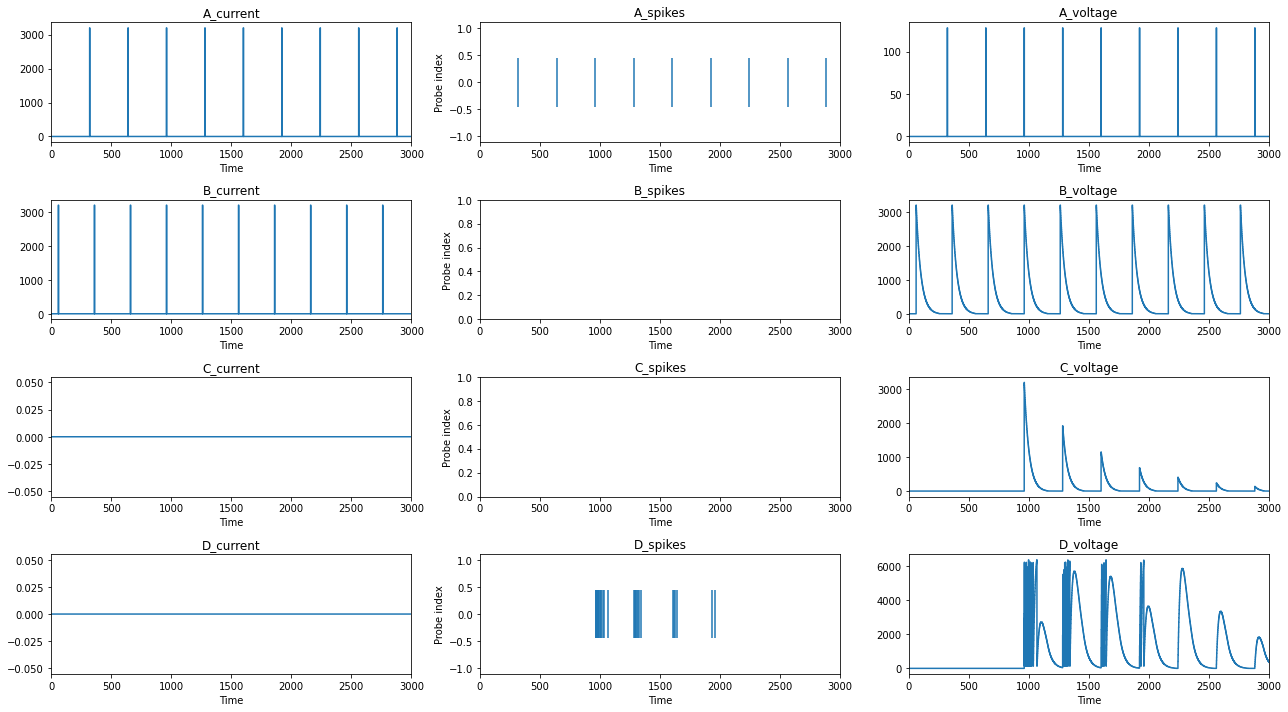

In [3]:
# Run a single TDE neuron for 3000 timesteps and plot current, spikes and voltage for all compartments
# in order to understand the basic TDE mechanism.
#
# As input, pairs of spikes to the facilitator and trigger compartment are given.
# At first, the trigger is 60 ts before the facilitator, but the facilitator catches up by 20 ts after every trial.
# So the first two spikes do not elicity any tde output. The third, where both inputs spike at the same time, induces the largest tde output.
# After that the spikes are 20 ts apart and a lower output is elicited. For 40 ts, it is even lower and for 80 ts, no output is elicited anymore.
# This behavior can be changed by changing the parameters (which is explored in the following cells).

params = {'fac_type': 'integrative', # can be 'integrative' or 'capped'
          'tau_fac': 40, # current tau of facilitator input
          'tau_trig': 40, # current tau of trigger input
          'tau_soma': 40, # voltage tau of TDE Neuron
          'wgt_fac': 2000, # amplitude of the facilitator spike
          'do_probes': 'all', # can be 'all', 'spikes' or None
          'num_neurons': 1,
         }

net = nx.NxNet()

# create the model with 1 neuron and plot
TDE = TDE_group(params=params, net=net)

spike_times_fac = np.arange(60, 3000, 300).tolist()
spike_times_trig = np.arange(0, 3000, 320).tolist()

indices_fac = np.zeros(len(spike_times_fac), dtype=int).tolist()
indices_trig = np.zeros(len(spike_times_trig), dtype=int).tolist()

TDE.add_spikes(spike_times_trig,indices_trig,spike_times_fac,indices_fac)

# run the model
net.run(3000)
net.disconnect()

TDE.plot()

INFO:DRV:  SLURM is being run in background
INFO:DRV:  Connecting to 10.212.98.108:44529
INFO:DRV:      Host server up..............Done 0.17s
INFO:DRV:      Encoding axons/synapses.....Done 1.34ms
INFO:DRV:      Compiling Embedded snips....Done 0.35s
INFO:DRV:      Compiling MPDS Registers....Done 0.73ms
INFO:HST:  Args chip=0 cpu=0 /homes/lyes_khacef/python3_venv/lib/python3.8/site-packages/nxsdk/driver/compilers/../../../temp/1635770857.4699461/launcher_chip0_lmt0.bin --chips=1 --epoch=0 --remote-relay=1 
INFO:HST:  Nx...
INFO:DRV:      Booting up..................Done 0.66s
INFO:DRV:      Encoding probes.............Done 0.65ms
INFO:DRV:      Transferring probes.........Done 2.69ms
INFO:DRV:      Configuring registers.......Done 5.25ms
INFO:DRV:      Transferring spikes.........Done 2.27ms
INFO:DRV:      Executing...................Done 0.11s
INFO:DRV:      Processing timeseries.......Done 0.05s
INFO:DRV:  Executor: 1000 timesteps........Done 1.38s
INFO:HST:  chip=0 cpu=0 halted, s

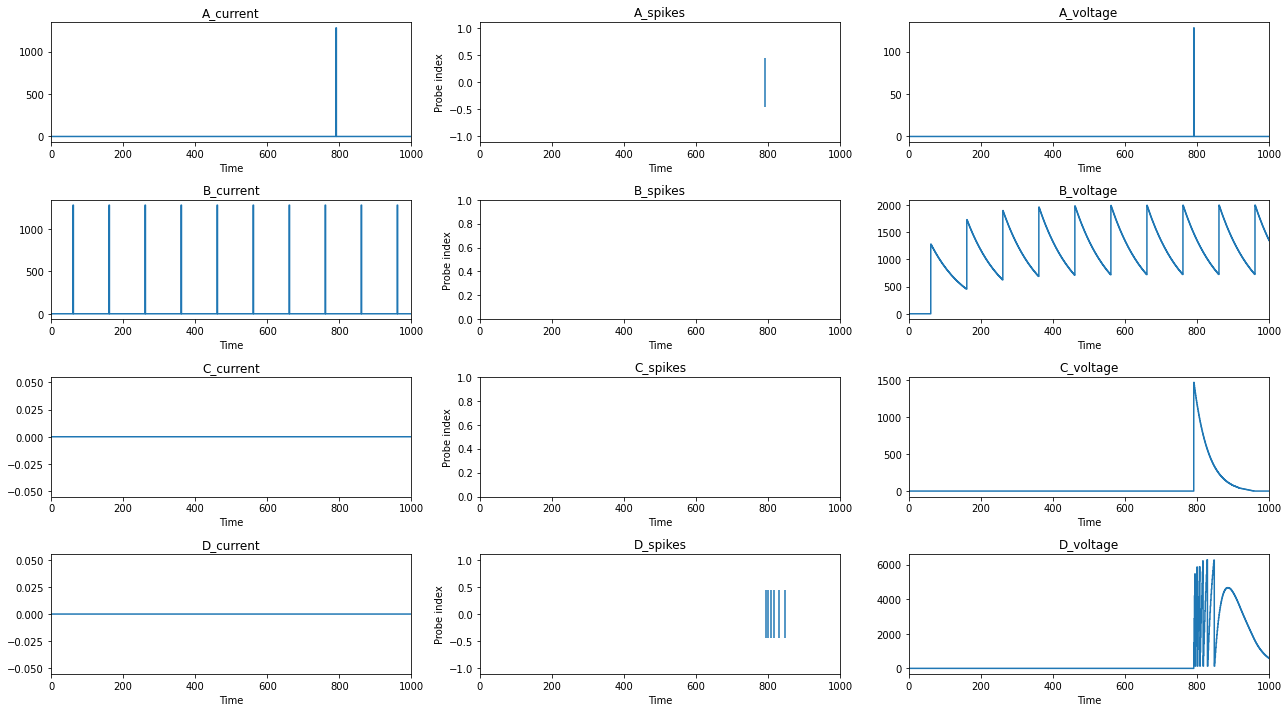

In [4]:
# Run a single integrative TDE neuron for 3000 timesteps and plot current, spikes and voltage for all compartments
# in order to understand how the integrative TDE behavior when the wgt_fac and tau_fac are big enough so that
# B's voltage does not decay completely before a next spike arrives with the fixed inter-spike interval.
#
# As input, pairs of spikes to the facilitator compartment are given, and one spike only to the trigger compartment.
# As observed in B's voltage, the effect of input spikes is integrated and approximates the rate of the spike rate
# over a short time window that can be modified with the decay time constants.
# We see that the TDE output is 6 spikes.

params = {'fac_type': 'integrative', # can be 'integrative' or 'capped'
          'tau_fac': 100, # current tau of facilitator input
          'tau_trig': 40, # current tau of trigger input
          'tau_soma': 40, # voltage tau of TDE Neuron
          'wgt_fac': 2000, # amplitude of the facilitator spike
          'do_probes': 'all', # can be 'all', 'spikes' or None
          'num_neurons': 1,
         }

net = nx.NxNet()
# create the model with 1 neuron and plot
TDE = TDE_group(params=params, net = net)

spike_times_fac = np.arange(60, 1000, 100).tolist()
spike_times_trig = [790]

indices_fac = np.zeros(len(spike_times_fac), dtype=int).tolist()
indices_trig = np.zeros(len(spike_times_trig), dtype=int).tolist()

TDE.add_spikes(spike_times_trig,indices_trig,spike_times_fac,indices_fac)

# run the model
net.run(1000)
net.disconnect()

TDE.plot()

print('The number of integrative TDE output spikes is', np.sum(TDE.probes['D_spikes'].data))

INFO:DRV:  SLURM is being run in background
INFO:DRV:  Connecting to 10.212.98.108:46859
INFO:DRV:      Host server up..............Done 0.18s
INFO:DRV:      Encoding axons/synapses.....Done 1.72ms
INFO:DRV:      Compiling Embedded snips....Done 0.35s
INFO:DRV:      Compiling MPDS Registers....Done 0.67ms
INFO:HST:  Args chip=0 cpu=0 /homes/lyes_khacef/python3_venv/lib/python3.8/site-packages/nxsdk/driver/compilers/../../../temp/1635770861.4172807/launcher_chip0_lmt0.bin --chips=1 --epoch=0 --remote-relay=1 
INFO:HST:  Nx...
INFO:DRV:      Booting up..................Done 0.65s
INFO:DRV:      Encoding probes.............Done 0.97ms
INFO:DRV:      Transferring probes.........Done 4.35ms
INFO:DRV:      Configuring registers.......Done 0.02s
INFO:DRV:      Transferring spikes.........Done 2.60ms
INFO:DRV:      Executing...................Done 0.11s
INFO:DRV:      Processing timeseries.......Done 0.04s
INFO:DRV:  Executor: 1000 timesteps........Done 1.39s
INFO:HST:  chip=0 cpu=0 halted, st

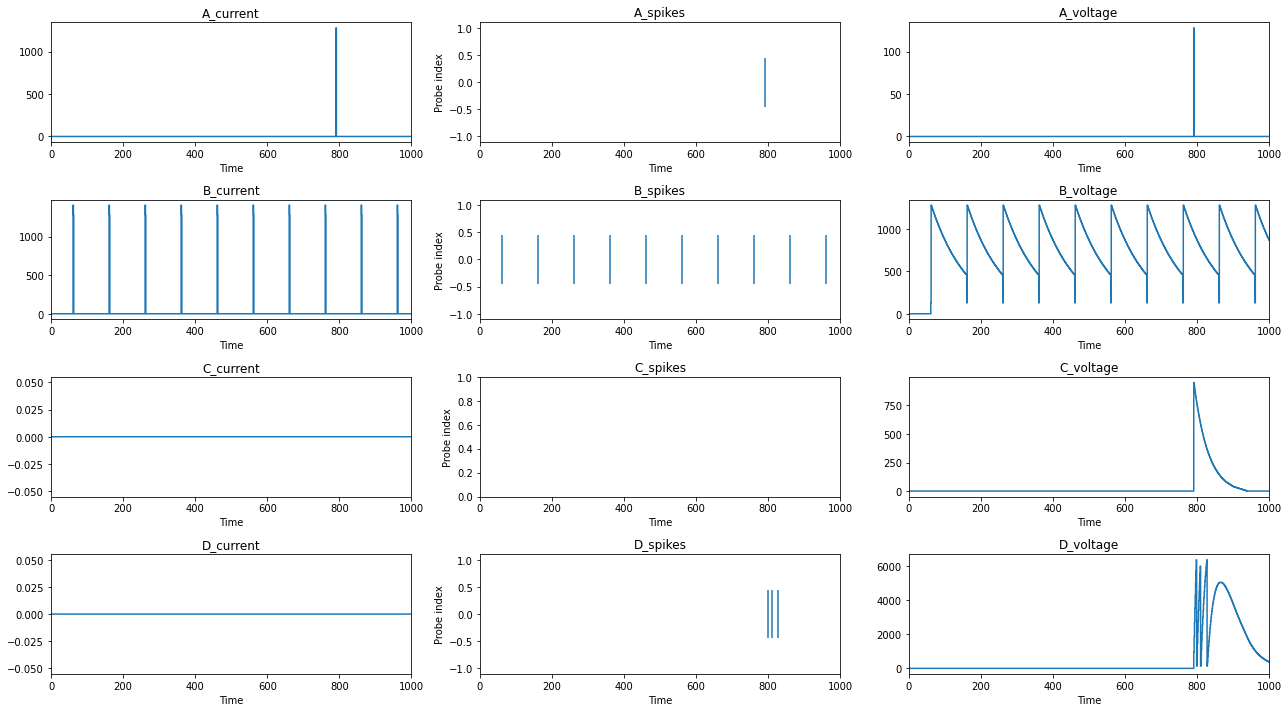

In [5]:
# Run a single integrative TDE neuron for 3000 timesteps and plot current, spikes and voltage for all compartments
# in order to understand how the integrative TDE behavior when the wgt_fac and tau_fac are big enough so that
# B's voltage does not decay completely before a next spike arrives with the fixed inter-spike interval.
#
# As input, pairs of spikes to the facilitator compartment are given, and one spike only to the trigger compartment.
# As observed in B's voltage, the effect of input spikes is capped and approximates the time since the last spike.
# We see that the TDE output is now 3 spikes only (vs. 6 for the integrative TDE), since only the time difference
# between the last facilitator spike and the trigger spike is encoded.

params = {'fac_type': 'capped', # can be 'integrative' or 'capped'
          'tau_fac': 100, # current tau of facilitator input
          'tau_trig': 40, # current tau of trigger input
          'tau_soma': 40, # voltage tau of TDE Neuron
          'wgt_fac': 2000, # amplitude of the facilitator spike
          'do_probes': 'all', # can be 'all', 'spikes' or None
          'num_neurons': 1,
         }

net = nx.NxNet()
# create the model with 1 neuron and plot
TDE = TDE_group(params=params, net=net)

spike_times_fac = np.arange(60, 1000, 100).tolist()
spike_times_trig = [790]

indices_fac = np.zeros(len(spike_times_fac), dtype=int).tolist()
indices_trig = np.zeros(len(spike_times_trig), dtype=int).tolist()

TDE.add_spikes(spike_times_trig,indices_trig,spike_times_fac,indices_fac)

# run the model
net.run(1000)
net.disconnect()

TDE.plot()

print('The number of capped TDE output spikes is', np.sum(TDE.probes['D_spikes'].data))

INFO:DRV:  SLURM is being run in background
INFO:DRV:  Connecting to 10.212.98.108:40839
INFO:DRV:      Host server up..............Done 0.17s
INFO:DRV:      Encoding axons/synapses.....Done 0.01s
INFO:DRV:      Compiling Embedded snips....Done 0.37s
INFO:DRV:      Compiling MPDS Registers....Done 2.35ms
INFO:HST:  Args chip=0 cpu=0 /homes/lyes_khacef/python3_venv/lib/python3.8/site-packages/nxsdk/driver/compilers/../../../temp/1635770865.3669724/launcher_chip0_lmt0.bin --chips=1 --epoch=0 --remote-relay=1 
INFO:HST:  Nx...
INFO:DRV:      Booting up..................Done 0.65s
INFO:DRV:      Encoding probes.............Done 1.37ms
INFO:DRV:      Transferring probes.........Done 0.01s
INFO:DRV:      Configuring registers.......Done 6.59ms
INFO:DRV:      Transferring spikes.........Done 3.93ms
INFO:DRV:      Executing...................Done 0.61s
INFO:DRV:      Processing timeseries.......Done 0.74s
INFO:DRV:  Executor: 300 timesteps.........Done 2.61s
INFO:HST:  chip=0 cpu=0 halted, sta

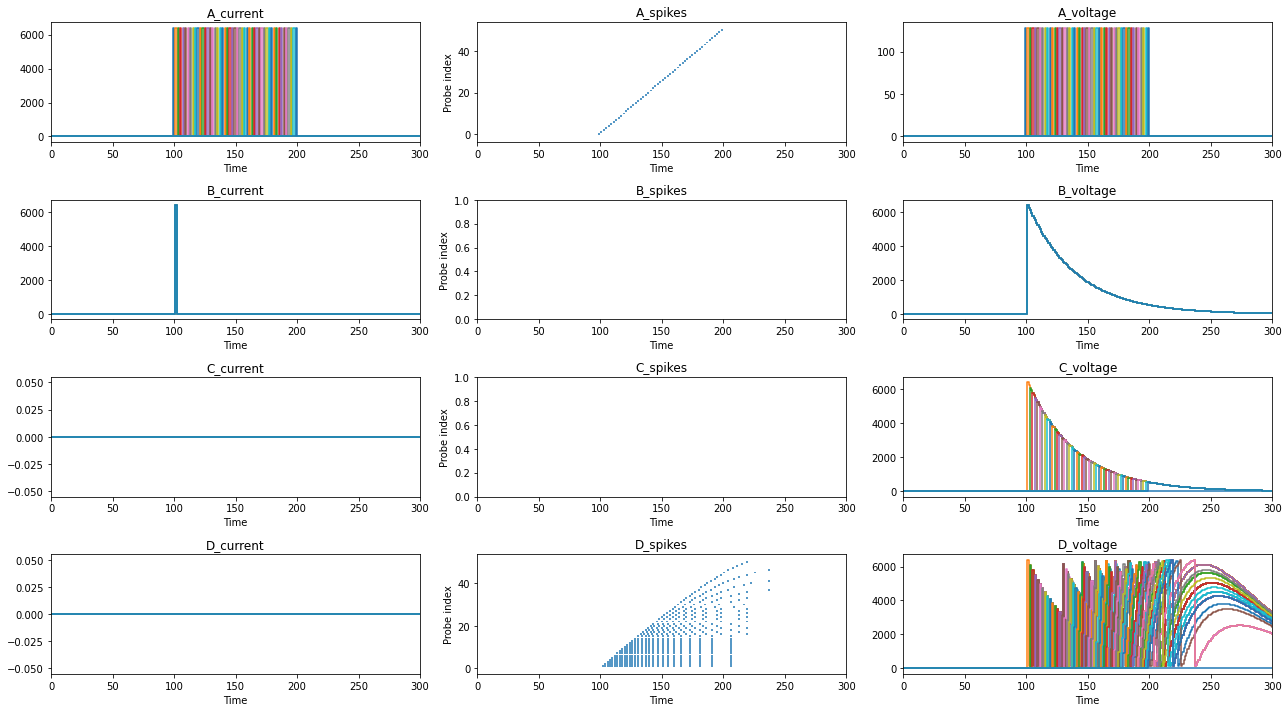

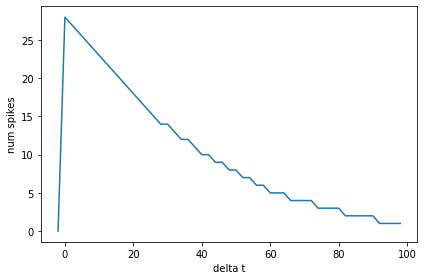

In [6]:
# create the network with 51 TDEs and delta timesteps from -2 to +100 

num_neurons=51
params = {'fac_type': 'integrative', # can be 'integrative' or 'capped'
          'tau_fac': 40, # current tau of facilitator input
          'tau_trig': 40, # current tau of trigger input
          'tau_soma': 40, # voltage tau of TDE Neuron
          'wgt_fac': 4000, # amplitude of the facilitator spike
          'do_probes': 'all', # can be 'all', 'spikes' or None
          'num_neurons': num_neurons,
         }


net = nx.NxNet()
TDE = TDE_group(params=params, net = net)

spike_times_fac = [100]*num_neurons
spike_times_trig = [98+ii*2 for ii in range(num_neurons)]

indices_trig = np.arange(0,num_neurons, dtype=int).tolist()
indices_fac = np.arange(0,num_neurons, dtype=int).tolist()

TDE.add_spikes(spike_times_trig,indices_trig,spike_times_fac,indices_fac)

# run the model
net.run(300)
net.disconnect()

TDE.plot()
plt.tight_layout()
plt.show()

spikes = np.sum(TDE.probes['D_spikes'].data,1)

plt.figure()
plt.plot(np.asarray(spike_times_trig)-100, spikes)
plt.xlabel('delta t')
plt.ylabel('num spikes')
plt.tight_layout()
plt.show()

desired value of normalized max weight: 66.66666666666667
actual value: 66 mantissa: 66 exponent: 0
desired value of normalized max weight: 33.333333333333336
actual value: 33 mantissa: 33 exponent: 0
desired value of normalized max weight: 28.571428571428573
actual value: 28 mantissa: 28 exponent: 0
desired value of normalized max weight: 13.333333333333334
actual value: 13 mantissa: 13 exponent: 0
INFO:DRV:  SLURM is being run in background
INFO:DRV:  Connecting to 10.212.98.108:39341
INFO:DRV:      Host server up..............Done 0.19s
INFO:DRV:      Encoding axons/synapses.....Done 0.22s
INFO:DRV:      Compiling Embedded snips....Done 0.36s
INFO:DRV:      Compiling MPDS Registers....Done 0.63ms
INFO:HST:  Args chip=0 cpu=0 /homes/lyes_khacef/python3_venv/lib/python3.8/site-packages/nxsdk/driver/compilers/../../../temp/1635770875.0288856/launcher_chip0_lmt0.bin --chips=1 --epoch=0 --remote-relay=1 
INFO:HST:  Nx...
INFO:DRV:      Booting up..................Done 0.69s
INFO:DRV:    

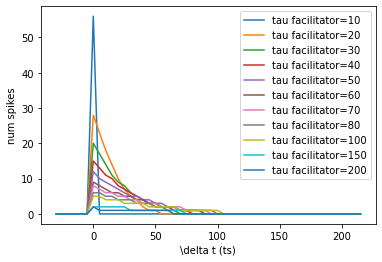

In [7]:
# explore the effect of the facilitator time constant

taus = [10,20,30,40,50,60,70,80,100,150,200]

# every neuron gets a different dt (per group)
num_neurons = 50

spike_times_fac = [100]*num_neurons
spike_times_trig = [70+ii*5 for ii in range(num_neurons)]

indices_fac = np.arange(0,num_neurons, dtype=int).tolist()
indices_trig = np.arange(0,num_neurons, dtype=int).tolist()

net = nx.NxNet()

TDEs = {}

for tau in taus:
    params = {'fac_type': 'integrative', # can be 'integrative' or 'capped'
              'tau_fac': tau, # current tau of facilitator input
              'tau_trig': 40, # current tau of trigger input
              'tau_soma': 40, # voltage tau of TDE Neuron
              'wgt_fac': 2000, # amplitude of the facilitator spike
              'do_probes': 'all', # can be 'all', 'spikes' or None
              'num_neurons': num_neurons,
             }
    TDEs[tau] = TDE_group(params=params, net = net)
    TDEs[tau].add_spikes(spike_times_trig,indices_trig,spike_times_fac,indices_fac)

# run the model
net.run(300)
net.disconnect()

spikes = {}
plt.figure()
for tau in taus:
    spikes[tau] = np.sum(TDEs[tau].probes['D_spikes'].data,1)
    plt.plot(np.asarray(spike_times_trig)-100, spikes[tau])

plt.xlabel('\delta t (ts)')
plt.ylabel('num spikes')
plt.legend(['tau facilitator='+str(tau) for tau in taus])


INFO:DRV:  SLURM is being run in background
INFO:DRV:  Connecting to 10.212.98.108:35409
INFO:DRV:      Host server up..............Done 0.17s
INFO:DRV:      Encoding axons/synapses.....Done 0.09s
INFO:DRV:      Compiling Embedded snips....Done 0.29s
INFO:DRV:      Compiling MPDS Registers....Done 0.61ms
INFO:HST:  Args chip=0 cpu=0 /homes/lyes_khacef/python3_venv/lib/python3.8/site-packages/nxsdk/driver/compilers/../../../temp/1635770892.263457/launcher_chip0_lmt0.bin --chips=1 --epoch=0 --remote-relay=1 
INFO:HST:  Nx...
INFO:DRV:      Booting up..................Done 0.70s
INFO:DRV:      Encoding probes.............Done 9.55ms
INFO:DRV:      Transferring probes.........Done 0.05s
INFO:DRV:      Configuring registers.......Done 0.03s
INFO:DRV:      Transferring spikes.........Done 0.02s
INFO:DRV:      Executing...................Done 7.16s
INFO:DRV:      Processing timeseries.......Done 5.44s
INFO:DRV:  Executor: 300 timesteps.........Done 14.04s
INFO:HST:  chip=0 cpu=0 halted, statu

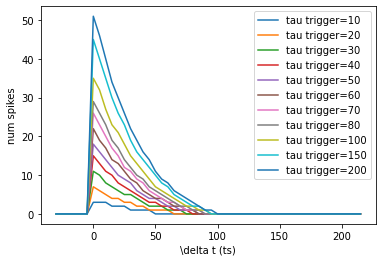

In [8]:
# explore the effect of the trigger time constant

taus = [10,20,30,40,50,60,70,80,100,150,200]

# every neuron gets a different dt (per group)
num_neurons = 50

spike_times_fac = [100]*num_neurons
spike_times_trig = [70+ii*5 for ii in range(num_neurons)]

indices_fac = np.arange(0,num_neurons, dtype=int).tolist()
indices_trig = np.arange(0,num_neurons, dtype=int).tolist()

net = nx.NxNet()

TDEs = {}

for tau in taus:
    params = {'fac_type': 'integrative', # can be 'integrative' or 'capped'
              'tau_fac': 40, # current tau of facilitator input
              'tau_trig': tau, # current tau of trigger input
              'tau_soma': 40, # voltage tau of TDE Neuron
              'wgt_fac': 2000, # amplitude of the facilitator spike
              'do_probes': 'all', # can be 'all', 'spikes' or None
              'num_neurons': num_neurons,
             }
    TDEs[tau] = TDE_group(params=params, net = net)
    TDEs[tau].add_spikes(spike_times_trig,indices_trig,spike_times_fac,indices_fac)

# run the model
net.run(300)
net.disconnect()

spikes = {}
plt.figure()
for tau in taus:
    spikes[tau] = np.sum(TDEs[tau].probes['D_spikes'].data,1)
    plt.plot(np.asarray(spike_times_trig)-100, spikes[tau])

plt.xlabel('\delta t (ts)')
plt.ylabel('num spikes')
plt.legend(['tau trigger='+str(tau) for tau in taus])


desired value of normalized max weight: 12.5
actual value: 12 mantissa: 12 exponent: 0
desired value of normalized max weight: 37.5
actual value: 37 mantissa: 37 exponent: 0
desired value of normalized max weight: 62.5
actual value: 62 mantissa: 62 exponent: 0
desired value of normalized max weight: 87.5
actual value: 87 mantissa: 87 exponent: 0
desired value of normalized max weight: 175.0
actual value: 174 mantissa: 87 exponent: 1
desired value of normalized max weight: 225.0
actual value: 224 mantissa: 112 exponent: 1
INFO:DRV:  SLURM is being run in background
INFO:DRV:  Connecting to 10.212.98.108:41201
INFO:DRV:      Host server up..............Done 0.18s
INFO:DRV:      Encoding axons/synapses.....Done 0.10s
INFO:DRV:      Compiling Embedded snips....Done 0.30s
INFO:DRV:      Compiling MPDS Registers....Done 0.88ms
INFO:HST:  Args chip=0 cpu=0 /homes/lyes_khacef/python3_venv/lib/python3.8/site-packages/nxsdk/driver/compilers/../../../temp/1635770909.848186/launcher_chip0_lmt0.bin

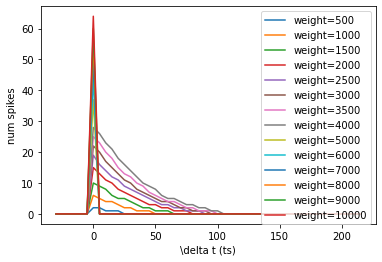

In [9]:
# explore the effect of the facilitator weight

pars = [500,1000,1500,2000,2500,3000,3500,4000,5000,6000,7000,8000,9000,10000]

# every neuron gets a different dt (per group)
num_neurons = 50

spike_times_fac = [100]*num_neurons
spike_times_trig = [70+ii*5 for ii in range(num_neurons)]

indices_fac = np.arange(0,num_neurons, dtype=int).tolist()
indices_trig = np.arange(0,num_neurons, dtype=int).tolist()

net = nx.NxNet()

TDEs = {}

for par in pars:
    params = {'fac_type': 'integrative', # can be 'integrative' or 'capped'
              'tau_fac': 40, # current tau of facilitator input
              'tau_trig': 40, # current tau of trigger input
              'tau_soma': 40, # voltage tau of TDE Neuron
              'wgt_fac': par, # amplitude of the facilitator spike
              'do_probes': 'all', # can be 'all', 'spikes' or None
              'num_neurons': num_neurons,
             }
    TDEs[par] = TDE_group(params=params, net = net)
    TDEs[par].add_spikes(spike_times_trig,indices_trig,spike_times_fac,indices_fac)

# run the model
net.run(300)
net.disconnect()

spikes = {}
plt.figure()
for par in pars:
    spikes[par] = np.sum(TDEs[par].probes['D_spikes'].data,1)
    plt.plot(np.asarray(spike_times_trig)-100, spikes[par])

plt.xlabel('\delta t (ts)')
plt.ylabel('num spikes')
plt.legend(['weight='+str(par) for par in pars])